In [8]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import copy
import sys

sys.path.append("..")

import time
import matplotlib.pyplot as plt
import bspline
import bspline.splinelab as splinelab


## Parameters for MC simulation of stock prices


In [3]:
S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.03      # risk-free rate
M = 1         # maturity
T = 10        # number of time steps

N_MC = 10000 # 10000 # 50000   # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

### Black-Scholes Simulation
Simulate $N_{MC}$ stock price sample paths with $T$ steps by the classical Black-Scholes formula.

$$dS_t=\mu S_tdt+\sigma S_tdW_t\quad\quad S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$

where $Z$ is a standard normal random variable.

Based on simulated stock price $S_t$ paths, compute state variable $X_t$ by the following relation.

$$X_t=-\left(\mu-\frac{1}{2}\sigma^2\right)t\Delta t+\log S_t$$

Also compute

$$\Delta S_t=S_{t+1}-e^{r\Delta t}S_t\quad\quad \Delta\hat{S}_t=\Delta S_t-\Delta\bar{S}_t\quad\quad t=0,...,T-1$$

where $\Delta\bar{S}_t$ is the sample mean of all values of $\Delta S_t$.

Plots of 10 stock price $S_t$ and state variable $X_t$ paths are shown below.


Time Cost: 0.07011079788208008 seconds


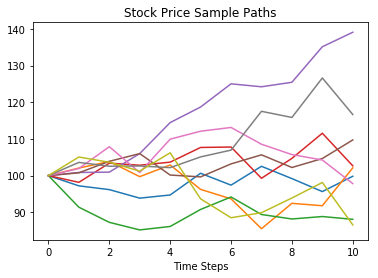

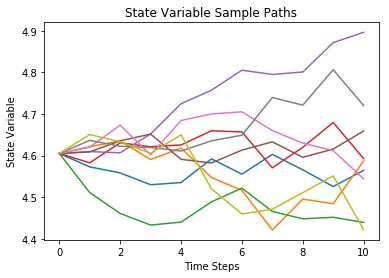

In [6]:
# make a dataset 

starttime = time.time()
np.random.seed(42) # Fix random seed
# stock price
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:,0] = S0

# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])

delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

# state variable
X = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S)   # delta_t here is due to their conventions

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.title('State Variable Sample Paths')
plt.show()

Define function *terminal_payoff* to compute the terminal payoff of a European put option.

$$H_T\left(S_T\right)=\max\left(K-S_T,0\right)$$

In [7]:
def terminal_payoff(ST, K):
    # ST   final stock price
    # K    strike
    payoff = max(K-ST, 0)
    return payoff

##  Define spline basis functions  

X.shape =  (10000, 11)
X_min, X_max =  4.050393734126806 5.128194977967483
Number of points k =  17


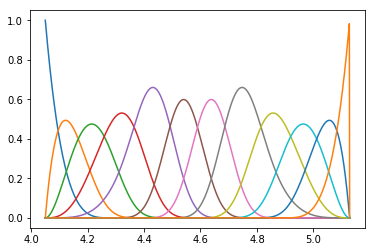

<Figure size 432x288 with 0 Axes>

In [9]:
X_min = np.min(np.min(X))
X_max = np.max(np.max(X))

print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

p = 4              # order of spline (as-is; 3 = cubic, 4: B-spline?)
ncolloc = 12

tau = np.linspace(X_min,X_max,ncolloc)  # These are the sites to which we would like to interpolate

# k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
# To get meaninful results, one should have ncolloc >= p+1
k = splinelab.aptknt(tau, p) 
                             
# Spline basis of order p on knots k
basis = bspline.Bspline(k, p)        
f = plt.figure()

# B   = bspline.Bspline(k, p)     # Spline basis functions 
print('Number of points k = ', len(k))
basis.plot()

plt.savefig('Basis_functions.png', dpi=600)


### Make data matrices with feature values

"Features" here are the values of basis functions at data points
The outputs are 3D arrays of dimensions num_tSteps x num_MC x num_basis

In [12]:
num_t_steps = T + 1
num_basis =  ncolloc # len(k) #

data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))

#print('num_basis = ', num_basis)
#print('dim data_mat_t = ', data_mat_t.shape)

# fill it, expand function in finite dimensional space
# in neural network the basis is the neural network itself
t_0 = time.time()
for i in np.arange(num_t_steps):
    x = X.values[:,i]
    data_mat_t[i,:,:] = np.array([ basis(el) for el in x ])
 
t_end = time.time()
print('Computational time:', t_end - t_0, 'seconds')

# save these data matrices for future re-use
np.save('data_mat_m=r_A_%d' % N_MC, data_mat_t)
#print(data_mat_t.shape)  # shape num_steps x N_MC x num_basis
#print(len(k))

Computational time: 0.25513219833374023 seconds


## Dynamic Programming solution for QLBS 

The MDP problem in this case is to solve the following Bellman optimality equation for the action-value function.

$$Q_t^\star\left(x,a\right)=\mathbb{E}_t\left[R_t\left(X_t,a_t,X_{t+1}\right)+\gamma\max_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1},a_{t+1}\right)\space|\space X_t=x,a_t=a\right],\space\space t=0,...,T-1,\quad\gamma=e^{-r\Delta t}$$

where $R_t\left(X_t,a_t,X_{t+1}\right)$ is the one-step time-dependent random reward and $a_t\left(X_t\right)$ is the action (hedge).


With this set of basis functions (to approximate this equation) $\left\{\Phi_n\left(X_t^k\right)\right\}_{n=1}^N$, expand the optimal action (hedge) $a_t^\star\left(X_t\right)$ and optimal Q-function $Q_t^\star\left(X_t,a_t^\star\right)$ in basis functions with time-dependent coefficients.
$$a_t^\star\left(X_t\right)=\sum_n^N{\phi_{nt}\Phi_n\left(X_t\right)}\quad\quad Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t\right)}$$

Coefficients $\phi_{nt}$ and $\omega_{nt}$ are computed recursively backward in time for $t=T−1,...,0$. 

Coefficients for expansions of the optimal action $a_t^\star\left(X_t\right)$ are solved by

$$\phi_t=\mathbf A_t^{-1}\mathbf B_t$$

where $\mathbf A_t$ and $\mathbf B_t$ are matrix and vector respectively with elements given by

$$A_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\Phi_m\left(X_t^k\right)\left(\Delta\hat{S}_t^k\right)^2}\quad\quad B_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\left[\hat\Pi_{t+1}^k\Delta\hat{S}_t^k+\frac{1}{2\gamma\lambda}\Delta S_t^k\right]}$$

We write *function_A* and *function_B* to compute the value of matrix $\mathbf A_t$ and vector $\mathbf B_t$.

## Define the option strike and risk aversion parameter

In [15]:
risk_lambda = 0.001 # 0.001 # 0.0001            # risk aversion
K = 100 # 

# Coef = 0 corresponds to a pure risk-based hedging

In [17]:
# functions to compute optimal hedges
def function_A_vec(t, delta_S_hat, data_mat, reg_param):
    """
    function_A_vec - compute the matrix A_{nm} from Eq. (52) (with a regularization!)
    Eq. (52) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    reg_param - a scalar, regularization parameter
    
    Return:
    - np.array, i.e. matrix A_{nm} of dimension num_basis x num_basis
    """

    # A_mat = your code goes here ...
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.loc[:, t]
    hat_dS2 = (this_dS ** 2).values.reshape(-1, 1)
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)

    return A_mat

def function_B_vec(t,
                   Pi_hat, 
                   delta_S_hat=delta_S_hat,
                   S=S,
                   data_mat=data_mat_t,
                   gamma=gamma,
                   risk_lambda=risk_lambda):
    """
    function_B_vec - compute vector B_{n} from Eq. (52) QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of delta_S_hat
    Pi_hat - pandas.DataFrame of dimension N_MC x T of portfolio values 
    delta_S_hat - pandas.DataFrame of dimension N_MC x T
    S - pandas.DataFrame of simulated stock prices
    data_mat - pandas.DataFrame of dimension T x N_MC x num_basis
    gamma - one time-step discount factor $exp(-r \delta t)$
    risk_lambda - risk aversion coefficient, a small positive number
    
    Return:
    B_vec - np.array() of dimension num_basis x 1
    """
    coef = 1.0/(2 * gamma * risk_lambda)
    # override it by zero to have pure risk hedge
    #coef = 0

    # B_vec = your code goes here ...
    tmp = Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t]
    X_mat = data_mat[t, :, :]  # matrix of dimension N_MC x num_basis
    B_vec = np.dot(X_mat.T, tmp)

    return B_vec

## Compute optimal hedge and portfolio value

Call *function_A* and *function_B* for $t=T-1,...,0$ together with basis function $\Phi_n\left(X_t\right)$ to compute optimal action $a_t^\star\left(X_t\right)=\sum_n^N{\phi_{nt}\Phi_n\left(X_t\right)}$ backward recursively with terminal condition $a_T^\star\left(X_T\right)=0$.

Once the optimal hedge $a_t^\star\left(X_t\right)$ is computed, the portfolio value $\Pi_t$ could also be computed backward recursively by 

$$\Pi_t=\gamma\left[\Pi_{t+1}-a_t^\star\Delta S_t\right]\quad t=T-1,...,0$$

together with the terminal condition $\Pi_T=H_T\left(S_T\right)=\max\left(K-S_T,0\right)$ for a European put option.

Also compute $\hat{\Pi}_t=\Pi_t-\bar{\Pi}_t$, where $\bar{\Pi}_t$ is the sample mean of all values of $\Pi_t$.

In [27]:

starttime = time.time()

# portfolio value
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])

# optimal hedge
a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a.iloc[:,-1] = 0

reg_param = 1e-3
for t in range(T-1, -1, -1):

    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t)

    # print ('t =  A_mat.shape = B_vec.shape = ', t, A_mat.shape, B_vec.shape)
    phi = np.dot(np.linalg.inv(A_mat), B_vec)

    a.loc[:,t] = np.dot(data_mat_t[t,:,:],phi)
    Pi.loc[:,t] = gamma * (Pi.loc[:,t+1] - a.loc[:,t] * delta_S.loc[:,t])
    Pi_hat.loc[:,t] = Pi.loc[:,t] - np.mean(Pi.loc[:,t])

a = a.astype('float')
Pi = Pi.astype('float')
Pi_hat = Pi_hat.astype('float')
endtime = time.time()
print('Computational time:', endtime - starttime, 'seconds')



Computational time: 0.15251493453979492 seconds


Plots of 5 optimal hedge $a_t^\star$ and portfolio value $\Pi_t$ paths are shown below.

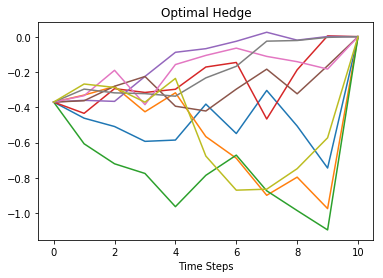

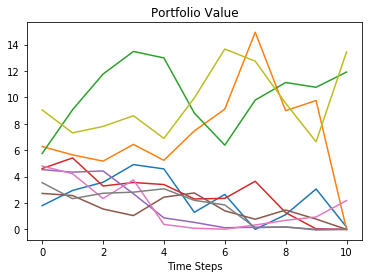

In [28]:
# plot 10 paths
plt.plot(a.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Optimal Hedge')
plt.show()

plt.plot(Pi.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Portfolio Value')
plt.show()

Once the optimal hedge $a_t^\star$ and portfolio value $\Pi_t$ are all computed, the reward function $R_t\left(X_t,a_t,X_{t+1}\right)$ could then be computed by

$$R_t\left(X_t,a_t,X_{t+1}\right)=\gamma a_t\Delta S_t-\lambda Var\left[\Pi_t\space|\space\mathcal F_t\right]\quad t=0,...,T-1$$

with terminal condition $R_T=-\lambda Var\left[\Pi_T\right]$.

Plot of 5 reward function $R_t$ paths is shown below.

## Part 2: Compute the optimal Q-function with the DP approach 

Coefficients for expansions of the optimal Q-function $Q_t^\star\left(X_t,a_t^\star\right)$ are solved by

$$\omega_t=\mathbf C_t^{-1}\mathbf D_t$$

where $\mathbf C_t$ and $\mathbf D_t$ are matrix and vector respectively with elements given by

$$C_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\Phi_m\left(X_t^k\right)}\quad\quad D_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\left(R_t\left(X_t,a_t^\star,X_{t+1}\right)+\gamma\max_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1},a_{t+1}\right)\right)}$$

In [22]:
def function_C_vec(t, data_mat, reg_param):
    """
    function_C_vec - calculate C_{nm} matrix from Eq. (56) (with a regularization!)
    Eq. (56) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat 
    data_mat - pandas.DataFrame of values of basis functions of dimension T x N_MC x num_basis
    reg_param - regularization parameter, a scalar
    
    Return:
    C_mat - np.array of dimension num_basis x num_basis
    """

    # C_mat = your code goes here ....
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    C_mat = np.dot(X_mat.T, X_mat) + reg_param * np.eye(num_basis_funcs)  


    return C_mat

def function_D_vec(t, Q, R, data_mat, gamma=gamma):
    """
    function_D_vec - calculate D_{nm} vector from Eq. (56) (with a regularization!)
    Eq. (56) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    Arguments:
    t - time index, a scalar, an index into time axis of data_mat 
    Q - pandas.DataFrame of Q-function values of dimension N_MC x T
    R - pandas.DataFrame of rewards of dimension N_MC x T
    data_mat - pandas.DataFrame of values of basis functions of dimension T x N_MC x num_basis
    gamma - one time-step discount factor $exp(-r \delta t)$
    
    Return:
    D_vec - np.array of dimension num_basis x 1
    """

    # D_vec = your code goes here ...
    X_mat = data_mat[t, :, :]
    D_vec = np.dot(X_mat.T, R.loc[:,t] + gamma * Q.loc[:, t+1])


    return D_vec

Call *function_C* and *function_D* for $t=T-1,...,0$ together with basis function $\Phi_n\left(X_t\right)$ to compute optimal action Q-function $Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t\right)}$ backward recursively with terminal condition $Q_T^\star\left(X_T,a_T=0\right)=-\Pi_T\left(X_T\right)-\lambda Var\left[\Pi_T\left(X_T\right)\right]$.

Compare the QLBS price to European put price given by Black-Sholes formula.

$$C_t^{\left(BS\right)}=Ke^{-r\left(T-t\right)}\mathcal N\left(-d_2\right)-S_t\mathcal N\left(-d_1\right)$$

In [23]:
# The Black-Scholes prices
def bs_put(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price


## Hedging and Pricing with Reinforcement Learning

The following is a batch-mode off-policy model-free Q-Learning by Fitted Q-Iteration. The only data available is given by a set of $N_{MC}$ paths for the underlying state variable $X_t$, hedge position $a_t$, instantaneous reward $R_t$ and the next-time value $X_{t+1}$.

$$\mathcal F_t^k=\left\{\left(X_t^k,a_t^k,R_t^k,X_{t+1}^k\right)\right\}_{t=0}^{T-1}\quad k=1,...,N_{MC}$$


Expand the Q-function through basis functions with time-dependent coefficients parametrized by a matrix $\mathbf W_t$.

$$Q_t^\star\left(X_t,a_t\right)=\mathbf A_t^T\mathbf W_t\Phi\left(X_t\right)=\mathbf A_t^T\mathbf U_W\left(t,X_t\right)=\vec{W}_t^T \vec{\Psi}\left(X_t,a_t\right)$$

$$\mathbf A_t=\left(\begin{matrix}1\\a_t\\\frac{1}{2}a_t^2\end{matrix}\right)\quad\mathbf U_W\left(t,X_t\right)=\mathbf W_t\Phi\left(X_t\right)$$

where $\vec{W}_t$ is obtained by concatenating columns of matrix $\mathbf W_t$ while 
$ \left( {\bf \Psi} \left(X_t,a_t \right) \right) = 
 \left( {\bf A}_t  \otimes {\bf \Phi}^T(X) \right) $ stands for 
a vector obtained by concatenating columns of the outer product of vectors $ {\bf A}_t $ and $ {\bf \Phi}(X) $.

We compute vector $\mathbf A_t$ then compute $\vec\Psi\left(X_t,a_t\right)$ for each $X_t^k$ and store in a dictionary with key path and time $\left[k,t\right]$.

## Make off-policy data

- **on-policy** data - contains an optimal action and the corresponding reward
- **off-policy** data - contains a random action and the corresponding reward

Given a large enough sample, i.e. N_MC tending to infinity, Q-Learner will learn an optimal policy from the data in a model-free setting.
In our case a random action is an optimal action + noise generated by sampling from uniform: distribution $$a_t\left(X_t\right) = a_t^\star\left(X_t\right) \sim U\left[1-\eta, 1 + \eta\right]$$

where $\eta$ is a disturbance level
In other words, each noisy action is calculated by taking optimal action computed previously and multiplying it by a uniform r.v. in the interval $\left[1-\eta, 1 + \eta\right]$ 

**So therefore, we will use synthetic trading data to better estimate the accuracy of this algorithm.** 


In the loop below:
 - Compute the optimal policy, and write the result to a_op
 - Now disturb these values by a random noise
 $$a_t\left(X_t\right) = a_t^\star\left(X_t\right) \sim U\left[1-\eta, 1 + \eta\right]$$
 - Compute portfolio values corresponding to observed actions
 $$\Pi_t=\gamma\left[\Pi_{t+1}-a_t^\star\Delta S_t\right]\quad t=T-1,...,0$$
 - Compute rewards corrresponding to observed actions
 $$R_t\left(X_t,a_t,X_{t+1}\right)=\gamma a_t\Delta S_t-\lambda Var\left[\Pi_t\space|\space\mathcal F_t\right]\quad t=T-1,...,0$$
with terminal condition $$R_T=-\lambda Var\left[\Pi_T\right]$$

In [24]:
eta = 0.5 #  0.5 # 0.25 # 0.05 # 0.5 # 0.1 # 0.25 # 0.15
reg_param = 1e-3
np.random.seed(42) # Fix random seed

# disturbed optimal actions to be computed 
a_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_op.iloc[:,-1] = 0

# also make portfolios and rewards
# portfolio value
Pi_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_op_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op_hat.iloc[:,-1] = Pi_op.iloc[:,-1] - np.mean(Pi_op.iloc[:,-1])

# reward function
R_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
R_op.iloc[:,-1] = - risk_lambda * np.var(Pi_op.iloc[:,-1])

# The backward loop
for t in range(T-1, -1, -1):

    
    # 1. Compute the optimal policy, and write the result to a_op
    a_op.loc[:, t] = a.loc[:, t]
    # 2. Now disturb these values by a random noise
    a_op.loc[:, t] *= np.random.uniform(1 - eta, 1 + eta, size=a_op.shape[0])
    # 3. Compute portfolio values corresponding to observed actions    
    Pi_op.loc[:,t] = gamma * (Pi_op.loc[:,t+1] - a_op.loc[:,t] * delta_S.loc[:,t])
    Pi_hat.loc[:,t] = Pi_op.loc[:,t] - np.mean(Pi_op.loc[:,t])
    
    # 4. Compute rewards corrresponding to observed actions
    R_op.loc[:,t] = gamma * a_op.loc[:,t] * delta_S.loc[:,t] - risk_lambda * np.var(Pi_op.loc[:,t])

print('done with backward loop!')

done with backward loop!


## Override on-policy data with off-policy data

In [30]:
# Override on-policy data with off-policy data

a = copy.deepcopy(a_op) # disturbed actions
Pi = copy.deepcopy(Pi_op)    # disturbed portfolio values
Pi_hat = copy.deepcopy(Pi_hat)
R = copy.deepcopy(R_op)


In [32]:
# make matrix A_t of shape (3 x num_MC x num_steps)
num_MC = a.shape[0] # number of simulated paths
num_TS = a.shape[1] # number of time steps
a_1_1 = a.values.reshape((1, num_MC, num_TS))

a_1_2 = 0.5 * a_1_1**2
ones_3d = np.ones((1, num_MC, num_TS))

A_stack = np.vstack((ones_3d, a_1_1, a_1_2))
#print(A_stack.shape)


In [33]:
data_mat_swap_idx = np.swapaxes(data_mat_t,0,2)

print(data_mat_swap_idx.shape) # (12, 10000, 25)

# expand dimensions of matrices to multiply element-wise
A_2 = np.expand_dims(A_stack, axis=1) # becomes (3,1,10000,25)
data_mat_swap_idx = np.expand_dims(data_mat_swap_idx, axis=0)  # becomes (1,12,10000,25)

Psi_mat = np.multiply(A_2, data_mat_swap_idx) # this is a matrix of size 3 x num_basis x num_MC x num_steps

# now concatenate columns along the first dimension
# Psi_mat = Psi_mat.reshape(-1, a.shape[0], a.shape[1], order='F')
Psi_mat = Psi_mat.reshape(-1, N_MC, T+1, order='F')

#print(Psi_mat.shape) #

(12, 10000, 11)


In [35]:
# make matrix S_t 

Psi_1_aux = np.expand_dims(Psi_mat, axis=1)
Psi_2_aux = np.expand_dims(Psi_mat, axis=0)
print(Psi_1_aux.shape, Psi_2_aux.shape)

S_t_mat = np.sum(np.multiply(Psi_1_aux, Psi_2_aux), axis=2) 

print(S_t_mat.shape)
# clean up some space
del Psi_1_aux, Psi_2_aux, data_mat_swap_idx, A_2


(36, 1, 10000, 11) (1, 36, 10000, 11)
(36, 36, 11)


## Calculate $\mathbf S_t$ and $\mathbf M_t$ marix and vector
Vector $\vec W_t$ can be solved by

$$\vec W_t=\mathbf S_t^{-1}\mathbf M_t$$

where $\mathbf S_t$ and $\mathbf M_t$ are matrix and vector respectively with elements given by

$$S_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Psi_n\left(X_t^k,a_t^k\right)\Psi_m\left(X_t^k,a_t^k\right)}\quad\quad M_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Psi_n\left(X_t^k,a_t^k\right)\left(R_t\left(X_t,a_t,X_{t+1}\right)+\gamma\max_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1},a_{t+1}\right)\right)}$$

Define function *function_S* and *function_M* to compute the value of matrix $\mathbf S_t$ and vector $\mathbf M_t$.


In [36]:
# vectorized functions

def function_S_vec(t, S_t_mat, reg_param):
    """
    function_S_vec - calculate S_{nm} matrix from Eq. (75) (with a regularization!)
    Eq. (75) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    num_Qbasis = 3 x num_basis, 3 because of the basis expansion (1, a_t, 0.5 a_t^2)
    
    Arguments:
    t - time index, a scalar, an index into time axis of S_t_mat 
    S_t_mat - pandas.DataFrame of dimension num_Qbasis x num_Qbasis x T
    reg_param - regularization parameter, a scalar
    Return:
    S_mat_reg - num_Qbasis x num_Qbasis
    """
    ### START CODE HERE ### (≈ 4-5 lines of code)
    # S_mat_reg = your code goes here ...
    num_Qbasis = S_t_mat.shape[0]
    S_mat_reg = S_t_mat[:,:,t] + reg_param * np.eye(num_Qbasis)
    ### END CODE HERE ###
    return S_mat_reg
   
def function_M_vec(t,
                   Q_star, 
                   R, 
                   Psi_mat_t, 
                   gamma=gamma):
    """
    function_S_vec - calculate M_{nm} vector from Eq. (75) (with a regularization!)
    Eq. (75) in QLBS Q-Learner in the Black-Scholes-Merton article
    
    num_Qbasis = 3 x num_basis, 3 because of the basis expansion (1, a_t, 0.5 a_t^2)
    
    Arguments:
    t- time index, a scalar, an index into time axis of S_t_mat 
    Q_star - pandas.DataFrame of Q-function values of dimension N_MC x T
    R - pandas.DataFrame of rewards of dimension N_MC x T
    Psi_mat_t - pandas.DataFrame of dimension num_Qbasis x N_MC
    gamma - one time-step discount factor $exp(-r \delta t)$
    Return:
    M_t - np.array of dimension num_Qbasis x 1
    """
    ### START CODE HERE ### (≈ 2-3 lines of code)
    # M_t = your code goes here ...
    M_t = np.dot(Psi_mat_t, R.loc[:,t] + gamma * Q_star.loc[:, t+1])
    ### END CODE HERE ###

    return M_t

Call *function_S* and *function_M* for $t=T-1,...,0$ together with vector $\vec\Psi\left(X_t,a_t\right)$ to compute $\vec W_t$ and learn the Q-function $Q_t^\star\left(X_t,a_t\right)=\mathbf A_t^T\mathbf U_W\left(t,X_t\right)$ implied by the input data backward recursively with terminal condition $Q_T^\star\left(X_T,a_T=0\right)=-\Pi_T\left(X_T\right)-\lambda Var\left[\Pi_T\left(X_T\right)\right]$.

When the vector $ \vec{W}_t $ is computed as per the above at time $ t $, 
we can convert it back to a matrix $ \bf{W}_t $ obtained from the vector $ \vec{W}_t $ by 
reshaping to the shape $ 3 \times M $.

We can now calculate the matrix $ {\bf U}_t $
at time $ t $ for the whole set of MC paths as follows (this is Eq.(65) from the paper in a matrix form):

$$  \mathbf U_{W} \left(t,X_t \right) = 
\left[\begin{matrix} \mathbf U_W^{0,k}\left(t,X_t \right) \\  
\mathbf U_W^{1,k}\left(t,X_t \right) \\ \mathbf U_W^{2,k} \left(t,X_t \right)
\end{matrix}\right]
= \bf{W}_t \Phi_t \left(t,X_t \right)  $$

Here the matrix $ {\bf \Phi}_t $ has the shape shape $ M \times N_{MC}$. 
Therefore, their dot product has dimension $ 3 \times N_{MC}$, as it should be. 

Once this matrix $ {\bf U}_t $ is computed, individual vectors $ {\bf U}_{W}^{1}, {\bf U}_{W}^{2}, {\bf U}_{W}^{3} $ for all MC paths are read off as rows of this matrix.

From here, we can compute the optimal action and optimal Q-function $Q^{\star}(X_t, a_t^{\star}) $ at the optimal action for a given step $ t $. This will be used to evaluate the $ \max_{a_{t+1} \in \mathcal{A}} Q^{\star} \left(X_{t+1}, a_{t+1} \right) $.


The optimal action and optimal Q-function with the optimal action could be computed by

$$a_t^\star\left(X_t\right)=\frac{\mathbb{E}_{t} \left[  \Delta \hat{S}_{t}  \hat{\Pi}_{t+1} + \frac{1}{2 \gamma \lambda} \Delta S_{t} \right]}{
  \mathbb{E}_{t} \left[ \left( \Delta \hat{S}_{t} \right)^2 \right]}\, , 
\quad\quad Q_t^\star\left(X_t,a_t^\star\right)=\mathbf U_W^{\left(0\right)}\left(t,X_t\right)+ a_t^\star \mathbf U_W^{\left(2\right)}\left(t,X_t\right) +\frac{1}{2}\left(a_t^\star\right)^2\mathbf U_W^{\left(2\right)}\left(t,X_t\right)$$

with terminal condition $a_T^\star=0$ and $Q_T^\star\left(X_T,a_T^\star=0\right)=-\Pi_T\left(X_T\right)-\lambda Var\left[\Pi_T\left(X_T\right)\right]$.

Plots of 10 optimal action $a_t^\star\left(X_t\right)$, optimal Q-function with optimal action $Q_t^\star\left(X_t,a_t^\star\right)$ and implied Q-function $Q_t^\star\left(X_t,a_t\right)$ paths are shown below.

In [38]:


starttime = time.time()
# implied Q-function by input data (using the first form in Eq.(68))
Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

# optimal action
a_opt = np.zeros((N_MC,T+1))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:,-1] = 0

# optimal Q-function with optimal action
Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]

# max_Q_star_next = Q_star.iloc[:,-1].values 
max_Q_star = np.zeros((N_MC,T+1))
max_Q_star[:,-1] = Q_RL.iloc[:,-1].values

num_basis = data_mat_t.shape[2]

reg_param = 1e-3
hyper_param =  1e-1

# The backward loop
for t in range(T-1, -1, -1):
    
    # calculate vector W_t
    S_mat_reg = function_S_vec(t,S_t_mat,reg_param) 
    M_t = function_M_vec(t,Q_star, R, Psi_mat[:,:,t], gamma)
    W_t = np.dot(np.linalg.inv(S_mat_reg),M_t)  # this is an 1D array of dimension 3M
    
    # reshape to a matrix W_mat  
    W_mat = W_t.reshape((3, num_basis), order='F')  # shape 3 x M 
    
    # make matrix Phi_mat
    Phi_mat = data_mat_t[t,:,:].T  # dimension M x N_MC

    # compute matrix U_mat of dimension N_MC x 3 
    U_mat = np.dot(W_mat, Phi_mat)
    
    # compute vectors U_W^0,U_W^1,U_W^2 as rows of matrix U_mat  
    U_W_0 = U_mat[0,:]
    U_W_1 = U_mat[1,:]
    U_W_2 = U_mat[2,:]

    # IMPORTANT!!! Instead, use hedges computed as in DP approach:
    # in this way, errors of function approximation do not back-propagate. 
    # This provides a stable solution, unlike
    # the first method that leads to a diverging solution 
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t)
    # print ('t =  A_mat.shape = B_vec.shape = ', t, A_mat.shape, B_vec.shape)
    phi = np.dot(np.linalg.inv(A_mat), B_vec)
    
    a_opt[:,t] = np.dot(data_mat_t[t,:,:],phi)
    a_star.loc[:,t] = a_opt[:,t] 
    
    '''    
    print("test "+str(t))
    print(str(Q_star.head())) 
    '''
    
    max_Q_star[:,t] = U_W_0 + a_opt[:,t] * U_W_1 + 0.5 * (a_opt[:,t]**2) * U_W_2       
    Q_star.iloc[:,t] = max_Q_star[:,t]
    # update dataframes     
    
    # update the Q_RL solution given by a dot product of two matrices W_t Psi_t
    Psi_t = Psi_mat[:,:,t].T  # dimension N_MC x 3M  
    Q_RL.loc[:,t] = np.dot(Psi_t, W_t)
    
    # trim outliers for Q_RL
    up_percentile_Q_RL =  95 # 95
    low_percentile_Q_RL = 5 # 5
    
    low_perc_Q_RL, up_perc_Q_RL = np.percentile(Q_RL.loc[:,t],[low_percentile_Q_RL,up_percentile_Q_RL])
    
    # print('t = %s low_perc_Q_RL = %s up_perc_Q_RL = %s' % (t, low_perc_Q_RL, up_perc_Q_RL))
    
    # trim outliers in values of max_Q_star:
    flag_lower = Q_RL.loc[:,t].values < low_perc_Q_RL
    flag_upper = Q_RL.loc[:,t].values > up_perc_Q_RL
    Q_RL.loc[flag_lower,t] = low_perc_Q_RL
    Q_RL.loc[flag_upper,t] = up_perc_Q_RL
  
endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')




Time Cost: 0.1992037296295166 seconds


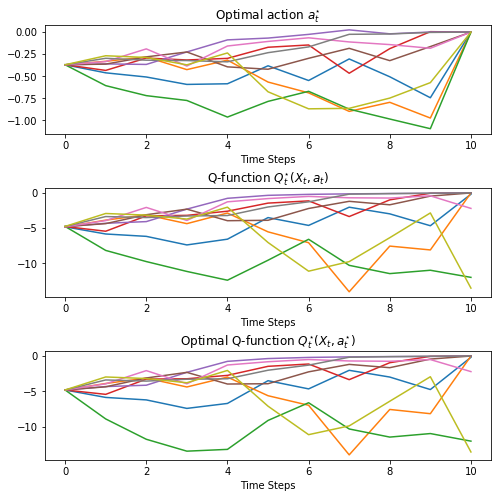

In [39]:
# plot both simulations
f, axarr = plt.subplots(3, 1)
f.subplots_adjust(hspace=.5)
f.set_figheight(8.0)
f.set_figwidth(8.0)

step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
axarr[0].plot(a_star.T.iloc[:, idx_plot]) 
axarr[0].set_xlabel('Time Steps')
axarr[0].set_title(r'Optimal action $a_t^{\star}$')

axarr[1].plot(Q_RL.T.iloc[:, idx_plot]) 
axarr[1].set_xlabel('Time Steps')
axarr[1].set_title(r'Q-function $Q_t^{\star} (X_t, a_t)$')

axarr[2].plot(Q_star.T.iloc[:, idx_plot]) 
axarr[2].set_xlabel('Time Steps')
axarr[2].set_title(r'Optimal Q-function $Q_t^{\star} (X_t, a_t^{\star})$') 

plt.savefig('QLBS_FQI_off_policy_summary_ATM_eta_%d.png' % (100 * eta), dpi=600)
plt.show()


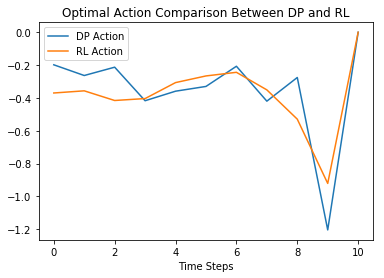

In [40]:
# plot a and a_star
# plot 1 path

num_path =  120 # 240 # 260 #  300 # 430 #  510

# Note that a from the DP method and a_star from the RL method are now identical by construction
plt.plot(a.T.iloc[:,num_path], label="DP Action")
plt.plot(a_star.T.iloc[:,num_path], label="RL Action")
plt.legend()
plt.xlabel('Time Steps')
plt.title('Optimal Action Comparison Between DP and RL')
plt.show()


In [41]:
C_QLBS.head()


NameError: name 'C_QLBS' is not defined

## Summary of the RL-based pricing with QLBS

In [42]:
# QLBS option price
C_QLBS = - Q_star.copy() # Q_RL # 
C_QLBS.head()

,0,1,2,3,4,5,6,7,8,9,10
1,4.797091,3.651501,3.570680,2.303101,0.786137,0.683388,0.557410,0.175043,0.121148,0.081914,0.044741
2,4.797091,5.393250,6.063143,5.179303,9.965395,16.283372,18.236486,21.544610,20.361662,23.854005,28.603304
3,4.797091,2.373334,2.307103,1.958528,3.640140,4.310843,3.541383,5.969046,4.318513,5.688032,6.476544
4,4.797091,5.678243,2.294515,2.035091,3.142646,1.629988,2.906627,1.991629,6.334344,11.177669,10.313079
5,4.797091,3.285533,2.729714,2.572523,2.667536,5.050161,6.436515,7.478584,3.713376,1.964171,7.841424


In [43]:
print('---------------------------------')
print('       QLBS RL Option Pricing       ')
print('---------------------------------\n')
print('%-25s' % ('Initial Stock Price:'), S0)
print('%-25s' % ('Drift of Stock:'), mu)
print('%-25s' % ('Volatility of Stock:'), sigma)
print('%-25s' % ('Risk-free Rate:'), r)
print('%-25s' % ('Risk aversion parameter :'), risk_lambda)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Maturity:'), M)
print('%-26s %.4f' % ('\nThe QLBS Put Price 1 :', (np.mean(C_QLBS.iloc[:,0]))))
print('%-26s %.4f' % ('\nBlack-Scholes Put Price:', bs_put(0)))
print('\n')

---------------------------------
       QLBS RL Option Pricing       
---------------------------------

Initial Stock Price:      100
Drift of Stock:           0.05
Volatility of Stock:      0.15
Risk-free Rate:           0.03
Risk aversion parameter : 0.001
Strike:                   100
Maturity:                 1

The QLBS Put Price 1 :    4.7971

Black-Scholes Put Price:  4.5296




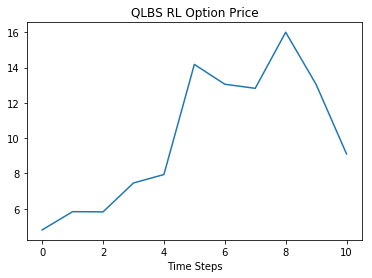

In [44]:
# plot one path
plt.plot(C_QLBS.T.iloc[:,[200]])
plt.xlabel('Time Steps')
plt.title('QLBS RL Option Price')
plt.show()

### Different MC parameters and tries

In [45]:


# add here calculation of different MC runs (6 repetitions of action randomization)

# on-policy values
y1_onp = 5.0211 # 4.9170
y2_onp = 4.7798 # 7.6500

# QLBS_price_on_policy = 4.9004 +/- 0.1206

# these are the results for noise eta = 0.15
# p1 = np.array([5.0174, 4.9249, 4.9191, 4.9039, 4.9705, 4.6216 ])
# p2 = np.array([6.3254, 8.6733, 8.0686, 7.5355, 7.1751, 7.1959 ])

p1 = np.array([5.0485, 5.0382, 5.0211, 5.0532, 5.0184])
p2 = np.array([4.7778, 4.7853, 4.7781,4.7805, 4.7828])

# results for eta = 0.25
# p3 = np.array([4.9339, 4.9243, 4.9224, 5.1643, 5.0449, 4.9176 ])
# p4 = np.array([7.7696,8.1922, 7.5440,7.2285, 5.6306, 12.6072])

p3 = np.array([5.0147, 5.0445, 5.1047, 5.0644, 5.0524])
p4 = np.array([4.7842,4.7873, 4.7847, 4.7792, 4.7796])

# eta = 0.35 
# p7 = np.array([4.9718, 4.9528, 5.0170, 4.7138, 4.9212, 4.6058])
# p8 = np.array([8.2860, 7.4012, 7.2492, 8.9926, 6.2443, 6.7755])

p7 = np.array([5.1342, 5.2288, 5.0905, 5.0784, 5.0013 ])
p8 = np.array([4.7762, 4.7813,4.7789, 4.7811, 4.7801])

# results for eta = 0.5
# p5 = np.array([4.9446, 4.9894,6.7388, 4.7938,6.1590, 4.5935 ])
# p6 = np.array([7.5632, 7.9250, 6.3491, 7.3830, 13.7668, 14.6367 ])

p5 = np.array([3.1459, 4.9673, 4.9348, 5.2998, 5.0636 ])
p6 = np.array([4.7816, 4.7814, 4.7834, 4.7735, 4.7768])

# print(np.mean(p1), np.mean(p3), np.mean(p5))
# print(np.mean(p2), np.mean(p4), np.mean(p6))
# print(np.std(p1), np.std(p3), np.std(p5))
# print(np.std(p2), np.std(p4), np.std(p6))

x = np.array([0.15, 0.25, 0.35, 0.5])
y1 = np.array([np.mean(p1), np.mean(p3), np.mean(p7), np.mean(p5)])
y2 = np.array([np.mean(p2), np.mean(p4), np.mean(p8), np.mean(p6)])
y_err_1 = np.array([np.std(p1), np.std(p3),np.std(p7),  np.std(p5)])
y_err_2 = np.array([np.std(p2), np.std(p4), np.std(p8), np.std(p6)])


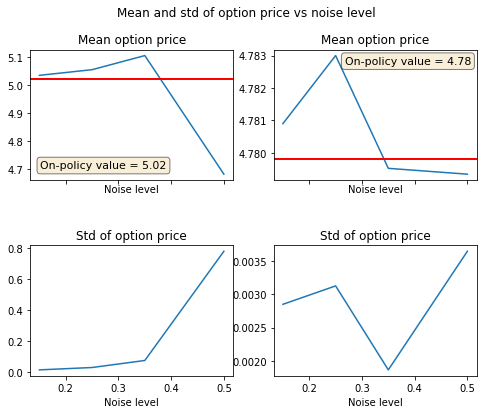

In [46]:
# plot it 
f, axs = plt.subplots(nrows=2, ncols=2, sharex=True)

f.subplots_adjust(hspace=.5)
f.set_figheight(6.0)
f.set_figwidth(8.0)

ax = axs[0,0]
ax.plot(x, y1)
ax.axhline(y=y1_onp,linewidth=2, color='r')
textstr = 'On-policy value = %2.2f'% (y1_onp)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)                      
# place a text box in upper left in axes coords
ax.text(0.05, 0.15, textstr, fontsize=11,transform=ax.transAxes, verticalalignment='top', bbox=props)
ax.set_title('Mean option price')
ax.set_xlabel('Noise level')

ax = axs[0,1]
ax.plot(x, y2)
ax.axhline(y=y2_onp,linewidth=2, color='r')
textstr = 'On-policy value = %2.2f'% (y2_onp)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)                      
# place a text box in upper left in axes coords
ax.text(0.35, 0.95, textstr, fontsize=11,transform=ax.transAxes, verticalalignment='top', bbox=props)
ax.set_title('Mean option price')
ax.set_xlabel('Noise level')

ax = axs[1,0]
ax.plot(x, y_err_1)
ax.set_title('Std of option price')
ax.set_xlabel('Noise level')

ax = axs[1,1]
ax.plot(x, y_err_2)
ax.set_title('Std of option price')
ax.set_xlabel('Noise level')

f.suptitle('Mean and std of option price vs noise level')

plt.savefig('Option_price_vs_noise_level.png', dpi=600)
plt.show()
